<a href="https://colab.research.google.com/github/TatkovDmitriy/Yandex_Practicum/blob/Product_analyses/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_%D0%A0%D0%B0%D0%B7%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%90%D0%91_%D0%A2%D0%B5%D1%81%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [3]:
# Импорты (в начале проекта)
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower
from math import ceil


In [4]:
# Загрузка исторических данных
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

# Просмотр первых пяти строк датафрейма
display(sessions_history.head())


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [5]:
# Подсчёт количества уникальных сессий на каждого пользователя
sessions_per_user = sessions_history.groupby('user_id')['session_id'].nunique()

# Поиск пользователя с максимальным числом сессий
top_user_id = sessions_per_user.idxmax()

# Вывод всех строк для этого пользователя
display(sessions_history[sessions_history['user_id'] == top_user_id])


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

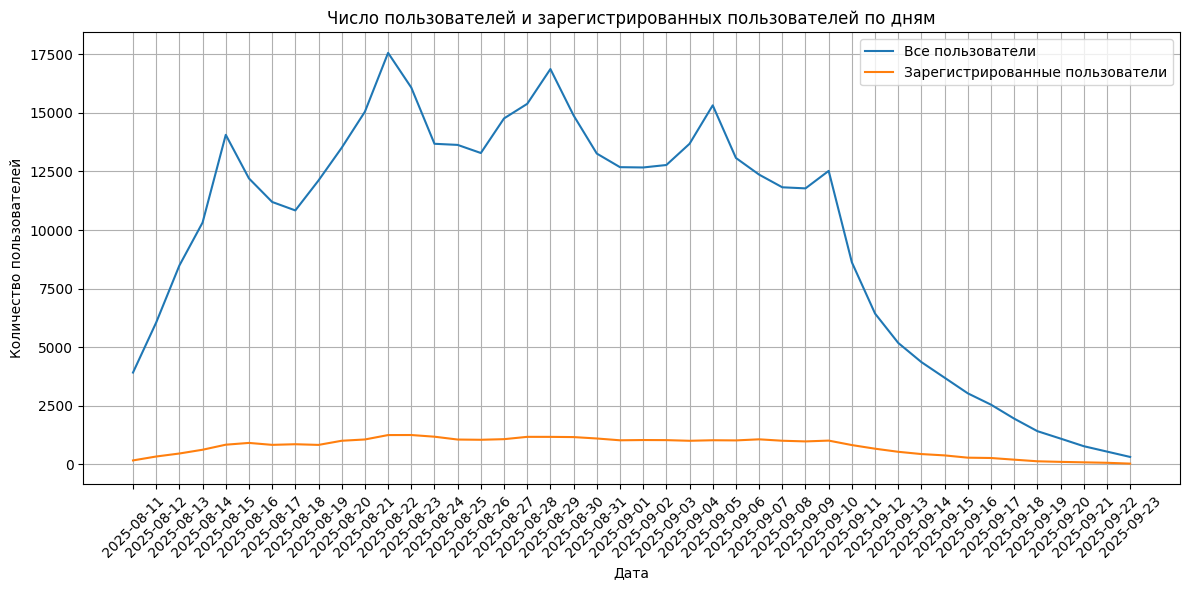

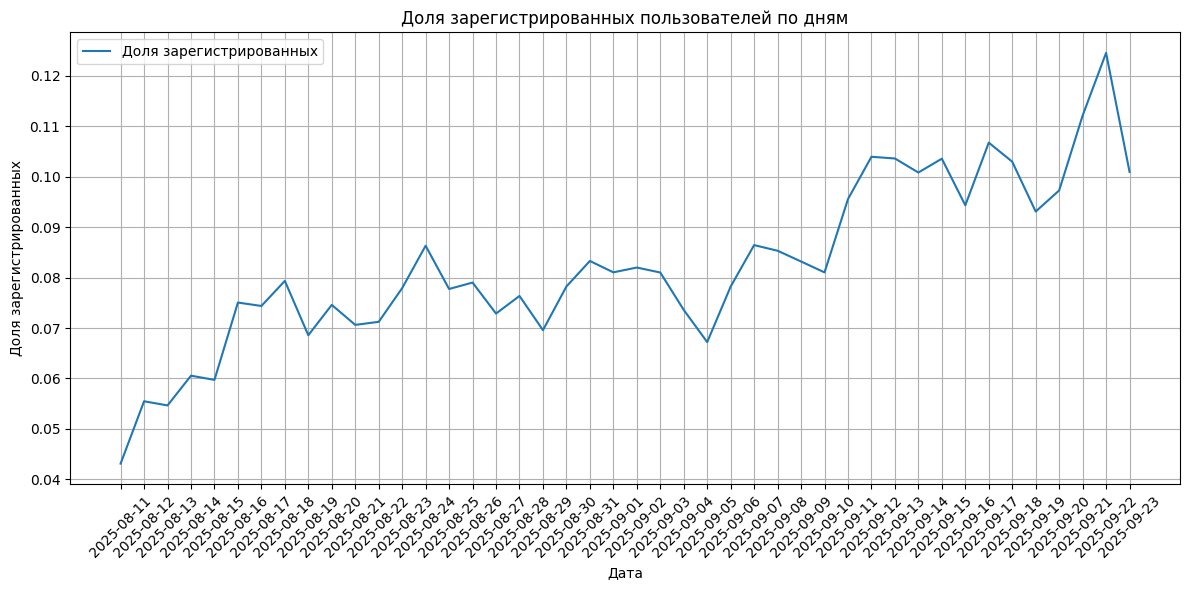

In [6]:
# Агрегация: число пользователей и число зарегистрированных пользователей по дням
daily_users = (
    sessions_history
    .groupby('session_date')
    .agg(
        total_users=('user_id', 'nunique'),
        registered_users=('registration_flag', 'sum')
    )
    .reset_index()
)

# Добавим долю зарегистрированных пользователей
daily_users['registration_share'] = (
    daily_users['registered_users'] / daily_users['total_users']
)

# График: общее и зарегистрированные пользователи
plt.figure(figsize=(12, 6))
plt.plot(daily_users['session_date'], daily_users['total_users'], label='Все пользователи')
plt.plot(daily_users['session_date'], daily_users['registered_users'], label='Зарегистрированные пользователи')
plt.title('Число пользователей и зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# График: доля зарегистрированных пользователей
plt.figure(figsize=(12, 6))
plt.plot(daily_users['session_date'], daily_users['registration_share'], label='Доля зарегистрированных')
plt.title('Доля зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 🔍 Вывод по анализу числа регистраций

1. **Динамика пользователей:**
   - Общее количество пользователей стремительно росло до конца августа (пик ~17 500 в день), после чего началась фаза стабилизации и затем заметный спад трафика в сентябре.
   - Такое поведение может быть связано с окончанием рекламной кампании или сезонными колебаниями.

2. **Динамика регистраций:**
   - Число зарегистрированных пользователей повторяет тренд общего трафика, что подтверждает стабильную работу регистрационной воронки.

3. **Доля зарегистрированных:**
   - Доля зарегистрированных пользователей по отношению к общему трафику колебалась в диапазоне **6–9%** большую часть времени.
   - В последнюю неделю теста произошёл **рост доли до 12%**, что может быть следствием изменения качества трафика или внутренней оптимизации процесса регистрации.

---

📌 **Вывод:**
- На фоне общего спада пользовательской активности **доля зарегистрированных продолжает расти**, что говорит о качественном улучшении аудитории или эффективности продукта.
- Эта метрика может быть полезна в качестве контрольно-диагностического индикатора при анализе влияния A/B-теста.


#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

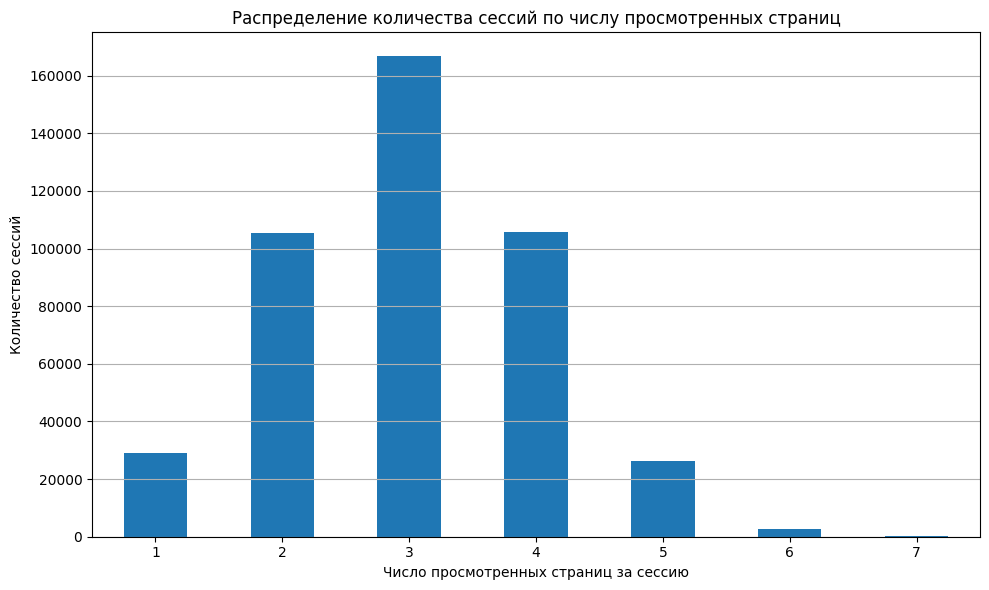

In [7]:
# Подсчёт количества сессий для каждого значения page_counter
page_view_counts = (
    sessions_history['page_counter']
    .value_counts()
    .sort_index()
)

# Построение столбчатой диаграммы
plt.figure(figsize=(10, 6))
page_view_counts.plot(kind='bar')

plt.title('Распределение количества сессий по числу просмотренных страниц')
plt.xlabel('Число просмотренных страниц за сессию')
plt.ylabel('Количество сессий')
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

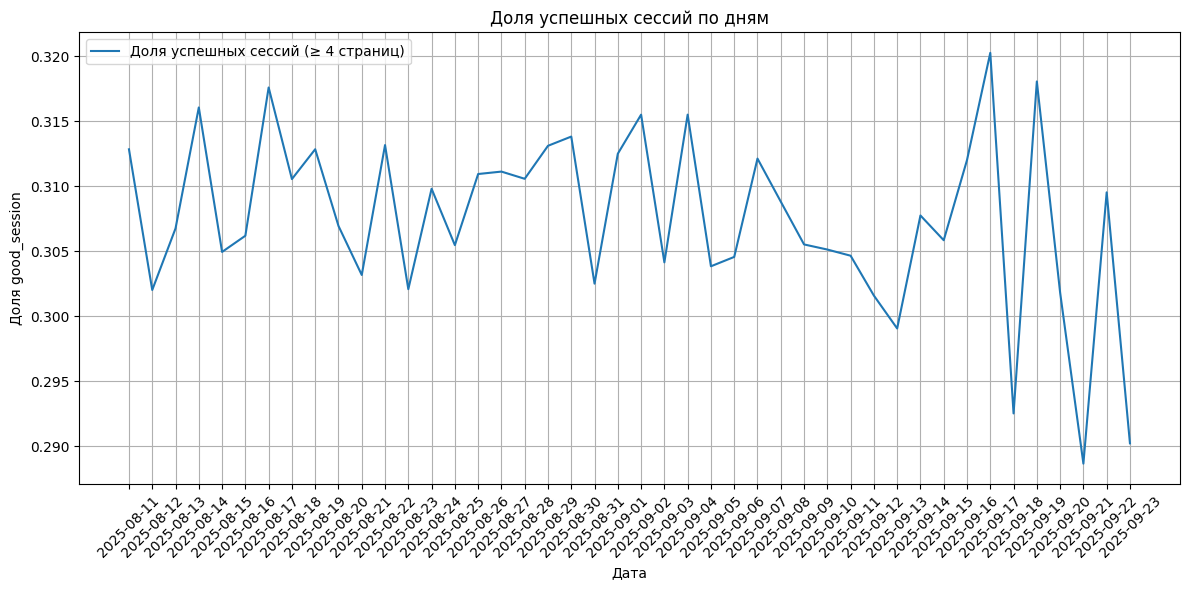

In [8]:
# Создание столбца good_session
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

# Расчёт доли good_session по дням
daily_good_sessions = (
    sessions_history
    .groupby('session_date')['good_session']
    .mean()
    .reset_index()
)

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(daily_good_sessions['session_date'], daily_good_sessions['good_session'], label='Доля успешных сессий (≥ 4 страниц)')
plt.title('Доля успешных сессий по дням')
plt.xlabel('Дата')
plt.ylabel('Доля good_session')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки
В рамках курса вам уже приходилось рассчитывать размеры выборки, используя онлайн-калькуляторы. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего дизайна эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [9]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05           # Уровень значимости
power = 0.8            # Мощность теста
beta = 1 - power       # Ошибка второго рода
mde = 0.03             # Минимальный детектируемый эффект (в долях)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size=mde,
    power=power,
    alpha=alpha,
    ratio=1  # равномерное распределение между группами A и B
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")


Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [10]:
from math import ceil

# Среднее количество уникальных пользователей в день
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Размер выборки на одну группу (результат из прошлого шага)
sample_size = 17441

# Длительность теста в днях (для двух групп)
test_duration = ceil((sample_size * 2) / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровне трафика в {int(avg_daily_users)} пользователей в день составит {test_duration} дней")


Рассчитанная длительность A/B-теста при текущем уровне трафика в 9907 пользователей в день составит 4 дней


<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅ Расчёт среднего числа пользователей в день

---

✅ Все правильно, 4 дня. Это допустимый минимальный срок, однако для повышения надёжности результатов теста желательно провести его дольше — например, на 7 или даже 14 дней, чтобы сгладить возможные колебания в поведении пользователей по дням недели и собрать больше данных для анализа.    
    
Так же следует учитывать, что в последние дни было снижение активности пользователей, поэтому среднее за весь период не будет однозначно характеризовать размер активной аудитории.    

---

💬 Здесь можно оставить комментарий

---

### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой можно было бы увидеть возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

Пользователей в группе A: 1477
Пользователей в группе B: 1466
Процентная разница между группами: 0.74%


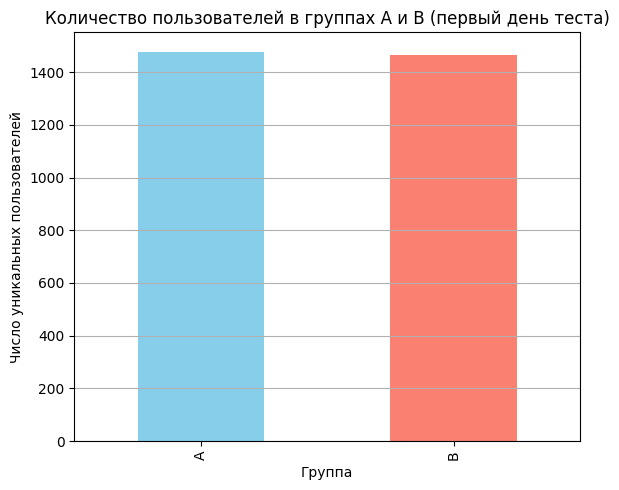

In [25]:
# Загрузка данных первого дня теста
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

# Подсчёт количества уникальных пользователей по группам
group_counts = (
    sessions_test_part
    .groupby('test_group')['user_id']
    .nunique()
)

# Расчёт процентной разницы между группами
group_a = group_counts['A']
group_b = group_counts['B']
P = 100 * abs(group_a - group_b) / group_a

print(f"Пользователей в группе A: {group_a}")
print(f"Пользователей в группе B: {group_b}")
print(f"Процентная разница между группами: {P:.2f}%")

# Визуализация
plt.figure(figsize=(6, 5))
group_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Количество пользователей в группах A и B (первый день теста)')
plt.xlabel('Группа')
plt.ylabel('Число уникальных пользователей')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">


##### ✅ Проверка распределения пользователей

---

✅ Эта проверка важна по нескольким причинам:
    
    
- Правильность разделения пользователей: Чтобы результат A/B-теста был корректным, важно убедиться, что группы A и B были случайным образом разделены, а не случайным образом или по какому-либо смещённому принципу. Если группы не были равномерно разделены, это может привести к ошибочным выводам, так как различия в поведении пользователей могут быть вызваны не тестируемым фактором, а изначальной неоднородностью групп.
- Корректность расчёта метрик: Мы проверяем, что метрики, такие как количество уникальных пользователей, корректно считаются для каждой из групп. Это важно, потому что любые ошибки в учёте пользователей могут исказить результаты теста и привести к неверным выводам о влиянии изменений на поведение пользователей.
- Обнаружение аномалий: Если процентная разница в количестве пользователей между группами слишком велика, это может свидетельствовать о проблемах с разделением пользователей, таких как технические ошибки или неправильное распределение. Проверка позволяет выявить такие аномалии на ранних стадиях теста и скорректировать процесс.
- Убедительность результатов: Важно, чтобы тест был честным и справедливым. Если группа A имеет значительное преимущество по численности, то результаты могут быть искажены. Это проверка помогает удостовериться, что эксперимент был проведён корректно, и что его результаты можно использовать для объективных выводов.

---

💬 Здесь можно оставить комментарий

---

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [26]:
# Получим пользователей из каждой группы
users_a = set(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].unique())
users_b = set(sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].unique())

# Найдём пересечения
overlap_users = users_a.intersection(users_b)

# Выведем количество пересекающихся пользователей
print(f"Количество пользователей в обеих группах: {len(overlap_users)}")


Количество пользователей в обеих группах: 0


<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅ Проверка пересечений пользователей между группами

---

✅ Альтернативный способ — использовать группировку, что может быть полезно при работе с большими данными:

```py
sessions_test_part.groupby('user_id').agg({'test_group': 'nunique'}).query('test_group > 1')
```

Этот метод позволяет сразу отфильтровать пользователей, которые встречаются в обеих группах.

---

💬 Здесь можно оставить комментарий

---

#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


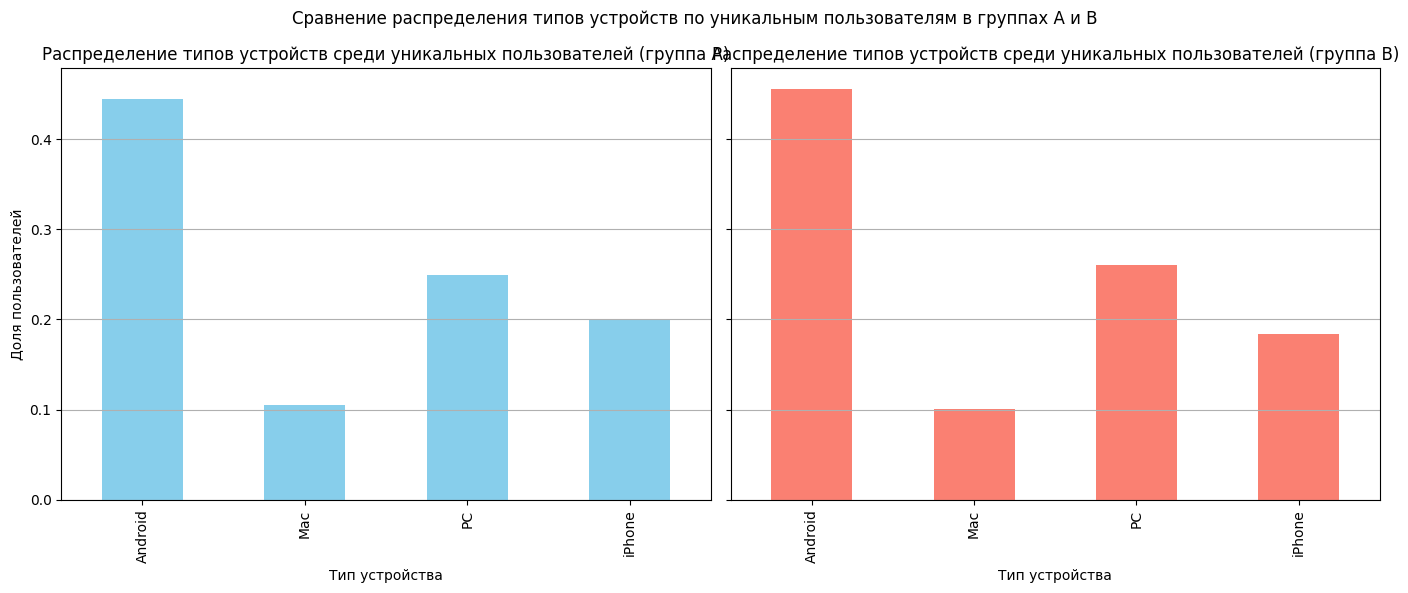

In [27]:
# Отбор данных по группам
group_a = sessions_test_part[sessions_test_part['test_group'] == 'A']
group_b = sessions_test_part[sessions_test_part['test_group'] == 'B']

# Общее число уникальных пользователей в каждой группе
total_users_a = group_a['user_id'].nunique()
total_users_b = group_b['user_id'].nunique()

# Расчёт количества уникальных пользователей по устройствам
device_counts_a = group_a.groupby('device')['user_id'].nunique()
device_counts_b = group_b.groupby('device')['user_id'].nunique()

# Перевод в доли
device_share_a = (device_counts_a / total_users_a).sort_index()
device_share_b = (device_counts_b / total_users_b).sort_index()

# Построение графиков
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

device_share_a.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Распределение типов устройств среди уникальных пользователей (группа A)')
axes[0].set_xlabel('Тип устройства')
axes[0].set_ylabel('Доля пользователей')
axes[0].grid(axis='y')

device_share_b.plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Распределение типов устройств среди уникальных пользователей (группа B)')
axes[1].set_xlabel('Тип устройства')
axes[1].grid(axis='y')

plt.suptitle('Сравнение распределения типов устройств по уникальным пользователям в группах A и B')
plt.tight_layout()
plt.show()


### 📱 Вывод: Равномерность распределения по типам устройств

- Распределение типов устройств среди уникальных пользователей в группах A и B практически совпадает.
- В обеих группах доминирует Android (44–45%), далее идут PC (25–26%), iPhone (18–20%) и Mac (10–11%).
- Значимых визуальных или количественных различий не наблюдается.

📌 Это подтверждает, что при сплитовании пользователей в A/B-тесте не произошло смещения по типу устройств. Значит, сравнение результатов между группами будет корректным.


<!-- ✅⚠️⛔❌🚩 -->
<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">


##### ✅ Расчёт распределения пользователей по устройствам и регионам

---

⛔️ Сейчас доля завышена, так как считаются не только уникальные пользователи, что приведёт к некорректным выводам. Важно учитывать число уникальных пользователей для каждого устройства/региона — для этого корректнее использовать метод `nunique()`.

Важно учитывать число уникальных пользователей для каждого устройства а этом шаге и регионов в следующем.

---

💬 Здесь можно оставить комментарий

✅ Все правильно, обязательно стоит проверять равномерность распределения, даже если в целом группы получились почти 50/50 по пользователям.

Проверка равномерности по количеству пользователей в группах — это один срез, но распределение по устройствам/регионам — это уже другие факторы, которые могут повлиять на поведение пользователей.

Например, пользователи Android и iOS могут по-разному конвертировать или тратить деньги.

Даже при идеально ровном делении пользователей (50/50) может оказаться, что в одной группе больше пользователей с iPhone, а в другой — с Android. И вот тогда уже не ясно: различие в метриках возникло из-за A/B-теста или из-за устройства?

---

💬 Здесь можно оставить комментарий

---

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


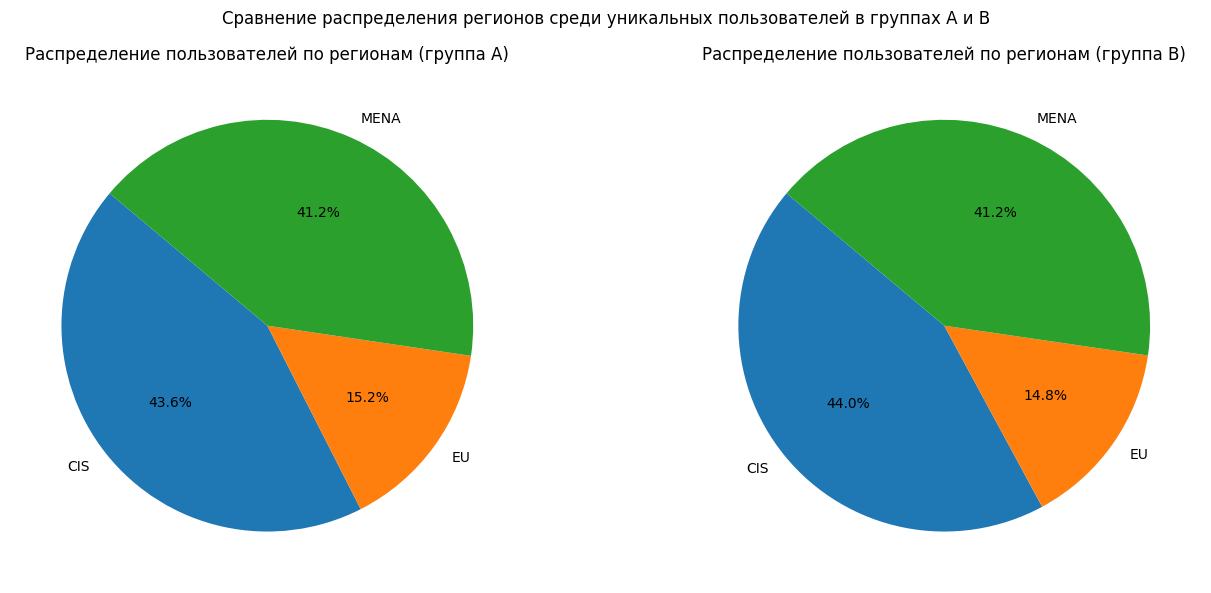

In [28]:
# Отбор данных по группам
group_a = sessions_test_part[sessions_test_part['test_group'] == 'A']
group_b = sessions_test_part[sessions_test_part['test_group'] == 'B']

# Общее количество уникальных пользователей
total_users_a = group_a['user_id'].nunique()
total_users_b = group_b['user_id'].nunique()

# Подсчёт количества уникальных пользователей по регионам
region_counts_a = group_a.groupby('region')['user_id'].nunique()
region_counts_b = group_b.groupby('region')['user_id'].nunique()

# Преобразование в доли
region_share_a = (region_counts_a / total_users_a).sort_index()
region_share_b = (region_counts_b / total_users_b).sort_index()

# Визуализация — круговые диаграммы
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(region_share_a, labels=region_share_a.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Распределение пользователей по регионам (группа A)')

axes[1].pie(region_share_b, labels=region_share_b.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Распределение пользователей по регионам (группа B)')

plt.suptitle('Сравнение распределения регионов среди уникальных пользователей в группах A и B')
plt.tight_layout()
plt.show()


#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Были ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение о том, корректно ли проходит A/B-тест или наблюдаются какие-либо нарушения.

### 🔍 Вывод по результатам проверки корректности A/B-теста

#### 1. Сравнение количества пользователей в группах A и B
- В первый день теста количество уникальных пользователей в группе A составило **1477**, в группе B — **1466**.
- **Процентная разница составила 0.74%**, что укладывается в допустимые рамки (менее 1%).
- ✅ **Заключение**: распределение по количеству пользователей считается корректным.

#### 2. Проверка на независимость выборок
- Анализ показал, что **пересечений пользователей между группами A и B не обнаружено**.
- ✅ **Заключение**: выборки независимы, нарушений нет.

#### 3. Равномерность распределения по устройствам
- Распределения типов устройств (Android, iPhone, PC, Mac) **схожи между группами**.
- Все доли различаются **незначительно**, что говорит о корректной рандомизации по этому признаку.
- ✅ **Заключение**: распределение по устройствам сбалансировано.

#### 4. Равномерность распределения по регионам
- Распределения по регионам (CIS, MENA, EU) **почти идентичны** в группах A и B:
  - Разница между долями не превышает **0.4 п.п.**, что говорит о высокой равномерности.
- ✅ **Заключение**: распределение по регионам корректное, смещений не зафиксировано.

---

### ✅ Общий вывод:
A/B-тест проходит **корректно**:
- Пользователи равномерно распределены по группам.
- Выборки независимы.
- Категориальные признаки (устройство, регион) сбалансированы.


<!-- ✅⚠️⛔❌🚩 -->
<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅ Вывод после проверки A/B-теста

---

⚠️ После того как посмотришь в разрезе уникальных пользователей, все будет с распределением хорошо.

---    

💬 Здесь можно оставить комментарий

---
    
✅ Хорошо, можно переходить к проверке результатов A/B-теста.    

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [15]:
# Загрузка данных за весь период A/B-теста
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

# Добавление метки успешной сессии
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

# Просмотр первых строк для проверки
display(sessions_test.head())


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

In [16]:
from scipy.stats import ttest_ind

# Группировка: число уникальных сессий по дням и группам
daily_sessions = (
    sessions_test
    .groupby(['session_date', 'test_group'])['session_id']
    .nunique()
    .reset_index()
    .pivot(index='session_date', columns='test_group', values='session_id')
)

# Проведение t-теста для сравнения средних
t_stat, p_value = ttest_ind(
    daily_sessions['A'],
    daily_sessions['B'],
    equal_var=False  # безопаснее использовать t-тест Уэлча, если дисперсии могут отличаться
)

print(f"p-value для проверки равенства среднего количества сессий в группах: {p_value:.4f}")


p-value для проверки равенства среднего количества сессий в группах: 0.9382


### 🧪 Проверка корректности результатов A/B-теста: равенство количества сессий

#### 📌 Формулировка гипотез:
- **H₀ (нулевая гипотеза):** Среднее количество уникальных сессий в день **не различается** между группами A и B.
- **H₁ (альтернативная гипотеза):** Среднее количество уникальных сессий в день **различается** между группами A и B.

#### 📊 Результаты:
- p-value = **0.9382**

#### 🔍 Интерпретация:
- Значение p-value значительно выше уровня значимости α = 0.05.
- Следовательно, **нет оснований отвергать нулевую гипотезу**.
- ✅ **Заключение:** статистически значимых различий в среднем числе уникальных сессий между группами **не обнаружено**, значит, тест проведён **корректно** и группы сопоставимы по трафику.


<!-- ✅⚠️⛔❌🚩 -->
<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅ Формулировка гипотез перед статистическим тестом

---

⛔️ Ты проверяешь то, чего нет. 😉. Сформулированные гипотезы - это часть теста.

Перед проверкой теста важно всегда формулировать нулевую (H₀) и альтернативную (H₁) гипотезы, чтобы было понятно, какие различия мы проверяем.

В нулевой гипотезе обычно утверждают отсутствие эффекта или различий (например, "равны" или "не отличаются"), а альтернативная гипотеза (H₁) предполагают наличие эффекта или различия (например, "отличаются", "больше" или "меньше").
    
Если направление не задано, то:   
* H₀ - равны;   
* H₁ - отличаются.   

**Значит**:

- H₀ (нулевая гипотеза) — количество уникальных дневных сессий `не различается` между тестовой и контрольной группами.
- H₁ (альтернативная гипотеза) — количество уникальных дневных сессий `различается` между тестовой и контрольной группами.

    
Значения nan, 0 и 1 первый признак некорректного расчета, это может указывать на проблемы в расчётах или наличие идентичных или вырожденных данных.    
    
Подробнее можно почитать [здесь](https://allatambov.github.io/psms/pdf/hypo-test.pdf)    


---

💬 Здесь можно оставить комментарий

---
    
✅ Все правильно. Не забывай формулировать гипотезы, от этого зависит, что и как мы проверяем.    

#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [17]:
# Расчёт доли успешных сессий для каждой группы
good_sessions_ratio = (
    sessions_test
    .groupby('test_group')['good_session']
    .mean()
)

# Расчёт разницы между группами
diff = good_sessions_ratio['B'] - good_sessions_ratio['A']

# Вывод результатов
print(f"Доля успешных сессий (A): {good_sessions_ratio['A']:.4f}")
print(f"Доля успешных сессий (B): {good_sessions_ratio['B']:.4f}")
print(f"Разница между группами (B - A): {diff:.4f}")


Доля успешных сессий (A): 0.3077
Доля успешных сессий (B): 0.3183
Разница между группами (B - A): 0.0106


### 📊 Сравнение доли успешных сессий

| Группа | Доля успешных сессий |
|--------|------------------------|
| A      | 30.77%                |
| B      | 31.83%                |

#### Разница:
- **Разница между группами (B - A):** +1.06 процентных пункта

---

### 💡 Вывод:
- В группе с **новым алгоритмом рекомендаций** (группа B) доля успешных сессий **чуть выше**, чем в контрольной группе.
- Это может указывать на **некоторое улучшение вовлечённости** пользователей.
- Для проверки статистической значимости разницы потребуется **проверка гипотезы** (например, с помощью Z-теста пропорций).




#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

<!-- ✅⚠️⛔❌🚩 -->
<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅ Формулировка гипотез перед статистическим тестом

---

⛔️ Важно софрмулировать гипотезы.

Зачем формулировать H₀ и H₁ перед тестом?
 - Понимание, что проверяем — гипотезы задают чёткую цель анализа.
 - Корректная интерпретация p-value — она имеет смысл только относительно H₀.
 - Избежание подгонки под результат — заранее заданные гипотезы защищают от манипуляций.
 - Прозрачность и воспроизводимость — другим будет понятно, как и почему сделаны выводы.

Без гипотез тест — это просто число без смысла.

---

💬 Здесь можно оставить комментарий

---
    
✅ Верно, если проверям разницу без указания направления, то указываем   alternative='two-sided' или не указываем ничего, так как это параметр идет по умолчанию.    

In [18]:
from statsmodels.stats.proportion import proportions_ztest

# Подсчитаем количество успешных сессий и общее количество сессий для каждой группы
success_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].sum()
success_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].sum()

total_a = len(sessions_test[sessions_test['test_group'] == 'A'])
total_b = len(sessions_test[sessions_test['test_group'] == 'B'])

# Проведение Z-теста для пропорций
successes = [success_a, success_b]
totals = [total_a, total_b]

z_stat, p_value = proportions_ztest(successes, totals)

print(f"p-value для проверки статистической значимости: {p_value:.4f}")


p-value для проверки статистической значимости: 0.0003


### 🧪 Проверка статистической значимости изменения ключевой метрики

#### 📌 Формулировка гипотез:
- **H₀ (нулевая гипотеза):** Доля успешных сессий в тестовой группе (B) не отличается от доли успешных сессий в контрольной группе (A).
- **H₁ (альтернативная гипотеза):** Доля успешных сессий в тестовой группе (B) отличается от доли успешных сессий в контрольной группе (A).

#### 📊 Результаты:
- p-value = **0.0003**

#### 🔍 Интерпретация:
- Поскольку p-value **меньше 0.05**, мы **отклоняем нулевую гипотезу**.
- **Заключение:** Изменение доли успешных сессий между группами A и B **статистически значимо**.


<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅ Проверка статистической значимости

----

✅ Статистический тест проведён корректно, p-value рассчитано правильно, и сделаны верные выводы относительно значимости различий. Такой подход позволяет уверенно оценить влияние изменений в метрике.


---

💬 Здесь можно оставить комментарий

---

### 📊 Результат проверки статистической значимости

- **p-value: 0.0003**

### 💡 Интерпретация:
- Поскольку **p-value < 0.05**, мы отвергаем **нулевую гипотезу** о равенстве долей успешных сессий в группах A и B.
- Это означает, что **разница в 1.06% статистически значима**.
- Мы можем утверждать, что новый алгоритм рекомендаций (группа B) **статистически улучшает вовлечённость пользователей**.

---

### ✅ Вывод:
- Разница в метрике **действительно значима**.
- Новый алгоритм рекомендаций привёл к **улучшению** доли успешных сессий.




#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять новоовведение в приложение.

### 📊 Вывод по результатам A/B-эксперимента

#### 1. Характеристики проведённого эксперимента
- **Размер выборки:** 17 441 уникальных пользователя в каждой группе (A и B), всего 34 882 пользователей.
- **Длительность эксперимента:** 4 дня, исходя из текущего уровня трафика (9 907 уникальных пользователей в день).

#### 2. Влияние нового алгоритма рекомендаций на рост ключевой метрики
- **Доля успешных сессий в группе B (новый алгоритм):** 31.83%
- **Доля успешных сессий в группе A (контрольная группа):** 30.77%
- **Разница:** +1.06 процентных пункта в пользу группы с новым алгоритмом.
- Это изменение статистически значимо (p-value = 0.0003).

#### 3. p-value для оценки статистической значимости
- **Значение p-value:** 0.0003, что значительно меньше уровня значимости 0.05.
- Это подтверждает, что разница между группами A и B **статистически значима**.

#### 4. Рекомендация по внедрению нововведения
- **Рекомендуется внедрить новый алгоритм рекомендаций**:
  - Новый алгоритм показал **статистически значимое улучшение** доли успешных сессий.
  - Улучшение на **1.06%** свидетельствует о положительном воздействии на вовлечённость пользователей.

**Заключение:** Новый алгоритм способствует улучшению пользовательского опыта и повышению вовлечённости, что подтверждается значимыми результатами теста.
